In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import MaxPooling2D, LayerNormalization
import concurrent.futures
from tqdm import tqdm
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [12]:
import sys
sys.path.append('../Functions')  # Add the relative path to FOLDER 2
sys.path.append('../Models')  # Add the relative path to FOLDER 3

from PIL import Image
from VisualizationFunctions import plot_image, plot_predicted_image, plot_loss_histograms
from ProcessingFunctions import preprocess_single_image, preprocess_images, remove_outliers
from ToyModel import build_toy_model
import tensorflow as tf
from LoadingFunctions import load_images_from_directory, data_generator
from BasicModel import BasicModel
from BatchNormModel import BatchNormModel
from TrainingFunctions import all_in_one



# Preprocessing

The problem that we will tackle in this notebook is how to colorize a greyscale image. 
Before proceeding with the preprocessing task, we must first explain how we plan to tackle the colorization problem. The idea is to use images in the LAB color scheme, which have 3 color channels structured in the following way:
- L channel: it has range [0,100] and represents the **lightness** of the image, with low values representing *black* and high values representing *white*
- a channel: it has range [-128,128] and represents the **green-magenta** color, with negative values towards the *green* and positive values towards the *magenta*
- b channel: it has range [-128,128] and represents the **blue-yellow** color, with negative values towards the *blue* and positive values towards the *yellow*

We can consider the input greyscale image as an image only expressing the first channel (L channel) in the LAB space, and the colorization task simply boils down to predicting the values of the other two channels, given the first one.

In order to perform this task, we need to preprocess the images in the following way:
- Images must be transformed from RGB color space to LAB color space
- LAB input must be normalized 
- Images which are by default black and white should be removed from the training data

In [2]:
height = 200  #height of the image after reshaping
width = 200   #width of the image after reshaping
directory = '/Users/alessandroardenghi/ImageColorizationProjectData/mirflickr/training'

## Preliminary Analysis I: only one image

In this section of the notebook, we explore a very simple convolutional neural network, trained and evaluate on the same image, just to see if all the preprocessing functions are working correctly

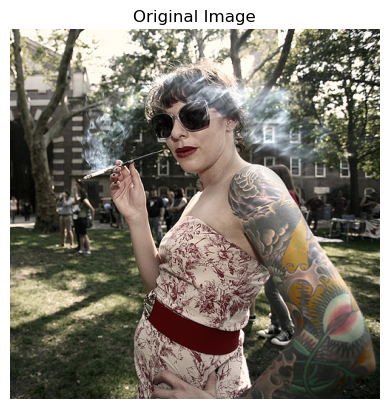

L channel shape:  (1, 200, 200, 1)
AB channel shape:  (1, 200, 200, 2)


In [3]:
image = Image.open(directory +'/im1.jpg')
plot_image(image)

size, X, Y = preprocess_single_image(image, height, width)

print("L channel shape: ", X.shape)
print("AB channel shape: ", Y.shape)

The channels are correctly separated. Now let's build a network!

In [4]:
model = build_toy_model()

# Fitting the NN to img1
model.fit(x=X, y=Y, batch_size=1, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 264ms/step - loss: 0.0048
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0041
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0039
Epoch 4/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0036
Epoch 5/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0033
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 7/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0025
Epoch 8/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0023
Epoch 9/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0026
Epoch 10/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 11/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0025
Epoch 12/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0024
Epoch 13/1000
1/1 [=================

1/1 [==============================] - 0s 62ms/step


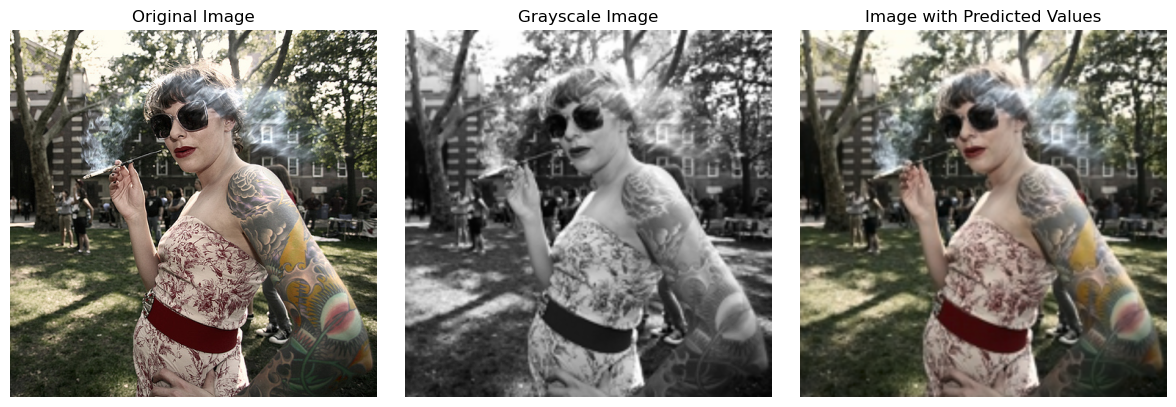

In [5]:
# Example usage of function "plot_predicted_image_1"

image = Image.open(directory +'/im1.jpg')
plot_predicted_image(image, model, 200, 200)


All the functions seem to be working well... Of course, we are not too impressed from the fact that this model can make a perfect prediction, as it was trained and tested only on one single image.

## Preliminary Analysis II: traning on 2 images

In [6]:
image1 = Image.open(directory + '/im1.jpg')
image2 = Image.open(directory + '/im3.jpg')

images = [image1, image2]

In [8]:
size, X_batch, Y_batch = preprocess_images(images, 200, 200)

In [9]:
model = build_toy_model()

model.fit(x=X_batch, y=Y_batch, batch_size=1, epochs=1000)

Epoch 1/1000


2/2 [==============================] - 0s 26ms/step - loss: 0.0134
Epoch 2/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0118
Epoch 3/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0092
Epoch 4/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0107
Epoch 5/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0096
Epoch 6/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0092
Epoch 7/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0094
Epoch 8/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0094
Epoch 9/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0090
Epoch 10/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0088
Epoch 11/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0091
Epoch 12/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0090
Epoch 13/1000
2/2 [==============================]

1/1 [==============================] - 0s 55ms/step


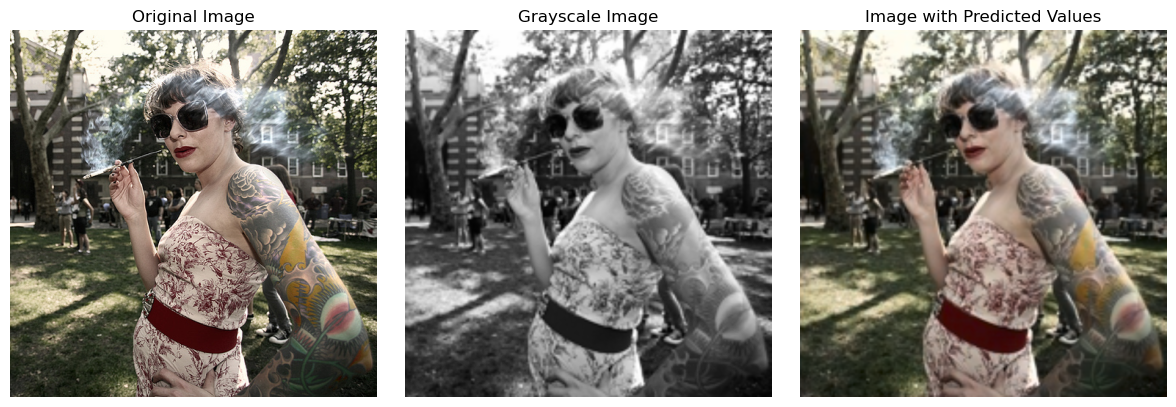

In [12]:
plot_predicted_image(images[0], model, 200, 200)


1/1 [==============================] - 0s 21ms/step


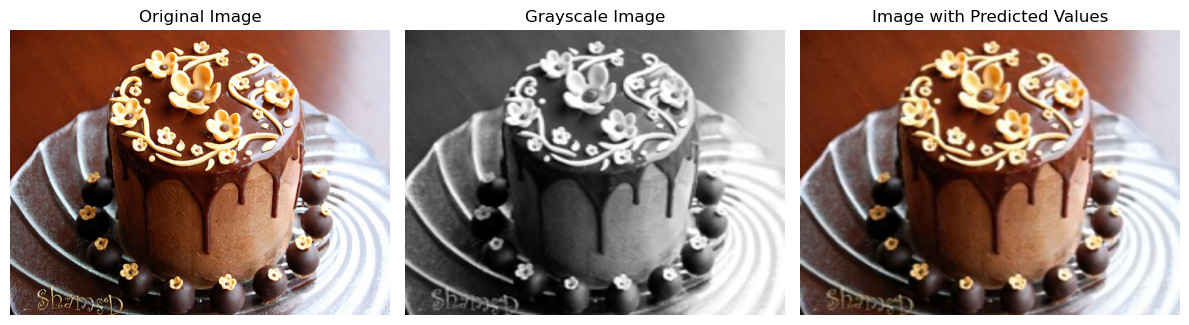

In [13]:
plot_predicted_image(images[1], model, 200, 200)

1/1 [==============================] - 0s 16ms/step


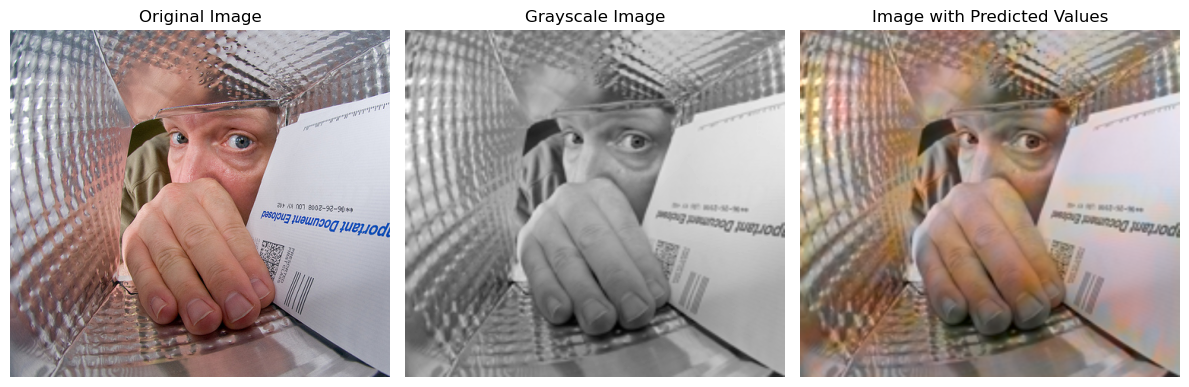

In [14]:
plot_predicted_image(Image.open(directory + '/im5.jpg'), model, 200, 200)

Although, as expected, the model performs well on the two training images, its performance is not particularly nice when faced with unseen images. 

## Models

In this section, we will train the data on more input images and see how its performance changes.

We partitioned the initial dataset in 2 subdatasets. The first one contains 20k images, whereas the second one contains the remaining 5k. We have also chosen to set up the **batch size** to 32 because, after having extensively experimented with different batch sizes, we found that this size is the one which yields the best predictions.

We will keep some parameters fixed during the comparison. These parameters are:
- **batch_size** = 32 (after extensive testing, we found that this batch size is the one which works best for us)
- **epochs** = 100 
- **steps_per_epoch** = 30 (given that the batch size is 32, at each epoch we train the model on 960 images)
- **patience** = 10

In [3]:
validation_directory = '/Users/alessandroardenghi/ImageColorizationProjectData/mirflickr/validation'
training_directory = '/Users/alessandroardenghi/ImageColorizationProjectData/mirflickr/training'
batch_size = 32
training_loss = []             #list in which we will store the training losses of the different models
validation_loss = []           #list in which we will store the training losses of the different models

In [4]:
validation_images = load_images_from_directory(validation_directory, 500)   #load 500 images for the validation
img_shape, X_val, Y_val = preprocess_images(validation_images, height, width)              #preprocess the 500 images 
X_val, Y_val = remove_outliers(X_val, Y_val, 0.2)                           #removing the images with the lowest values in the a and b channels

In [5]:
train_dataloader = data_generator(training_directory, 32, height, width)                  #setting up the dataloader

## First Model: A Naive Approach

In [6]:
Basic_Model = BasicModel(height, width)
Basic_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 2)       578       
                                                                 
Total params: 19682 (76.88 KB)
Trainable params: 19682 (76.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The first model that we implement is a very simple and shallow one. It is composed of only 3 convolutional layers, with a total number of trainable parameters of 19,682, and will be useful as a benchmark to see how a very simple model performs.

Epoch 1/100
30/30 [==============================] - 46s 2s/step - loss: 0.0210 - val_loss: 0.0196
Epoch 2/100
30/30 [==============================] - 47s 2s/step - loss: 0.0203 - val_loss: 0.0198
Epoch 3/100
30/30 [==============================] - 47s 2s/step - loss: 0.0204 - val_loss: 0.0198
Epoch 4/100
30/30 [==============================] - 47s 2s/step - loss: 0.0204 - val_loss: 0.0195
Epoch 5/100
30/30 [==============================] - 47s 2s/step - loss: 0.0198 - val_loss: 0.0199
Epoch 6/100
30/30 [==============================] - 47s 2s/step - loss: 0.0200 - val_loss: 0.0197
Epoch 6: early stopping
1/1 [==============================] - 0s 64ms/step


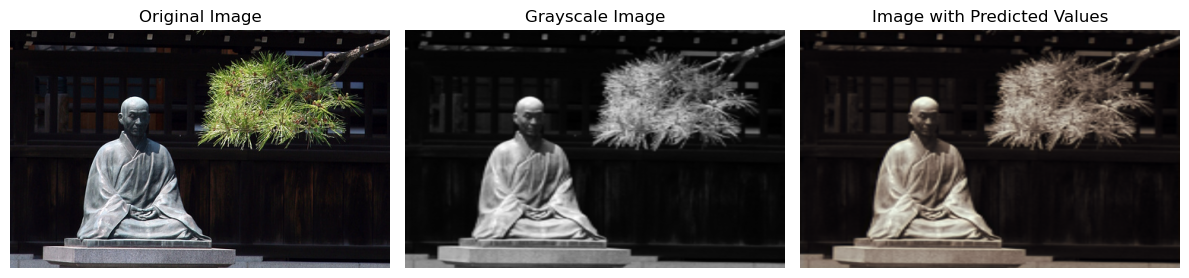

1/1 [==============================] - 0s 27ms/step


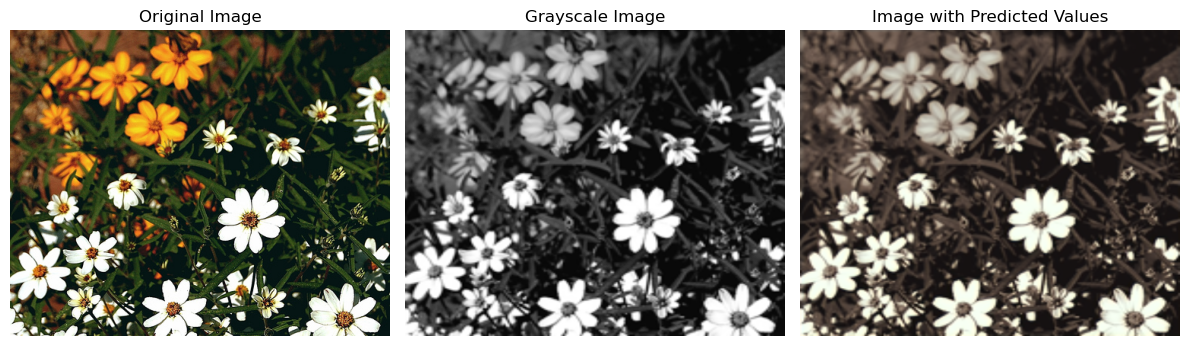

1/1 [==============================] - 0s 44ms/step


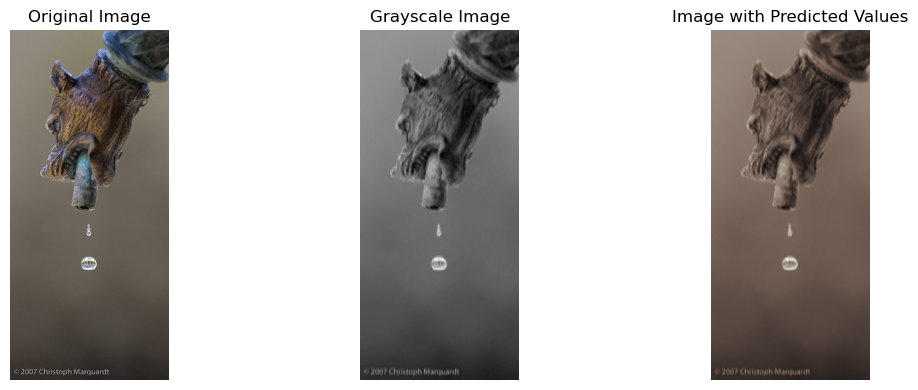

In [8]:
basic_t_loss, basic_v_loss = all_in_one(Basic_Model, train_dataloader, (X_val, Y_val), epochs = 100, steps_per_epoch = 30, patience = 5, directory = validation_directory, n = 3, pictures = True)

What we notice after this first attempt is that the predictions are not of really high quality, and the model tends to color everything with this "sand" color.

## Second Model: Batch Norm and Up Sampling

In [9]:
Batch_Norm_Model = BatchNormModel(height, width)

Batch_Norm_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 200, 200, 1)       4         
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 8)       80        
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 8)       584       
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 8)       32        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 16)      1168      
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 16)       

                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 16)      4624      
                                                                 
 conv2d_12

This second model in deeper and more complicated than the previous one, and features 6 blocks, where the first two are simply composed of 2 convolutional layers and one batch normalization layer, whereas the others have 2 convolutional layers and one upsampling layer. 

It is worth noticing that we have chosen the kernel size to always be the same (i.e. (3x3)), and also the activation function to be almost always **ReLU**. The only exception is the last layer, where we chose a **tanh** as activation function, because we wanted our final values to be in the range [-1,1], which is indeed the image of the hyperbolic tangent.

Epoch 1/100
30/30 [==============================] - 16s 529ms/step - loss: 0.0233 - val_loss: 0.0217
Epoch 2/100
30/30 [==============================] - 16s 537ms/step - loss: 0.0207 - val_loss: 0.0209
Epoch 3/100
30/30 [==============================] - 17s 566ms/step - loss: 0.0206 - val_loss: 0.0207
Epoch 4/100
30/30 [==============================] - 16s 548ms/step - loss: 0.0206 - val_loss: 0.0203
Epoch 5/100
30/30 [==============================] - 16s 541ms/step - loss: 0.0200 - val_loss: 0.0205
Epoch 6/100
30/30 [==============================] - 20s 651ms/step - loss: 0.0200 - val_loss: 0.0203
Epoch 7/100
30/30 [==============================] - 19s 647ms/step - loss: 0.0205 - val_loss: 0.0200
Epoch 8/100
30/30 [==============================] - 19s 616ms/step - loss: 0.0189 - val_loss: 0.0199
Epoch 9/100
30/30 [==============================] - 18s 616ms/step - loss: 0.0199 - val_loss: 0.0197
Epoch 10/100
30/30 [==============================] - 17s 568ms/step - loss: 0.019

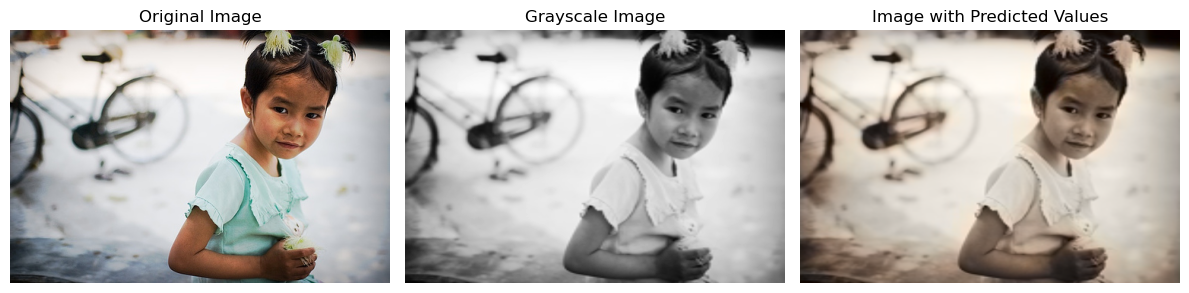

1/1 [==============================] - 0s 21ms/step


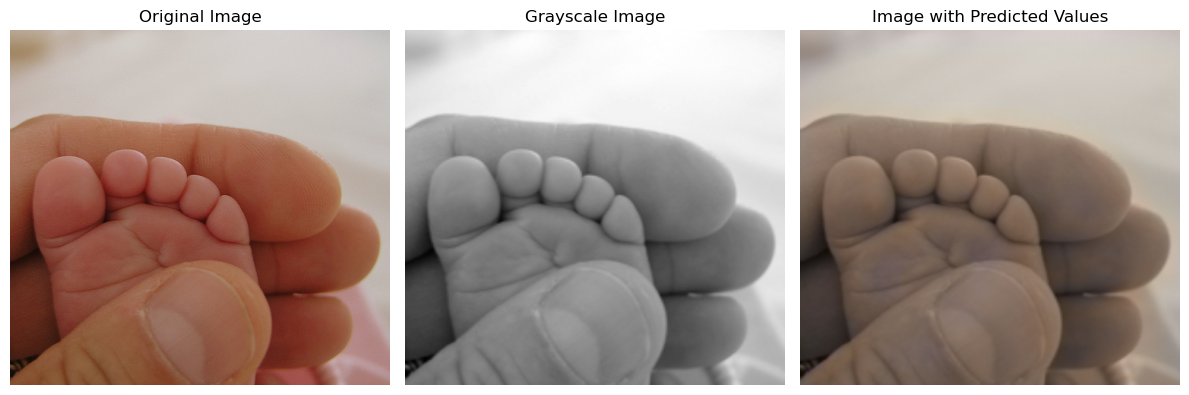

1/1 [==============================] - 0s 15ms/step


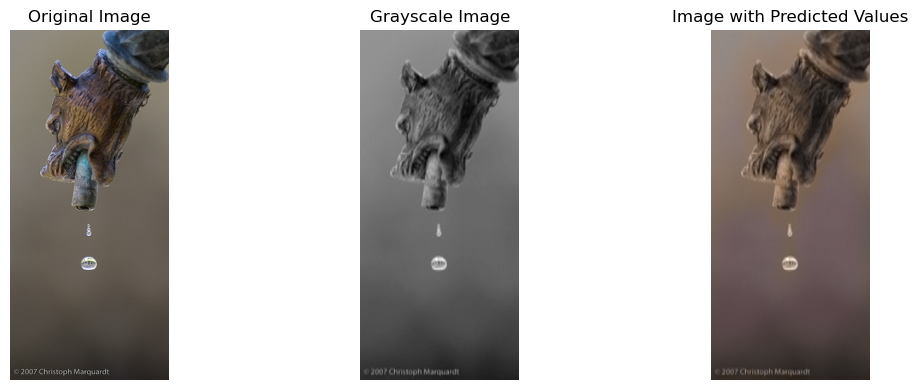

In [10]:
batch_t_loss, batch_v_loss = all_in_one(Batch_Norm_Model, train_dataloader, (X_val, Y_val), epochs = 100, steps_per_epoch = 30, patience = 10, directory = validation_directory, n = 3, pictures = True)

In [13]:
training_loss.append(basic_t_loss)             
validation_loss.append(basic_v_loss)
training_loss.append(batch_t_loss)             
validation_loss.append(batch_v_loss)

As we can notice, this second model has not provided particularly good predictions (although already better than the benchmark model). On a positive note, it seems that the model has been able to notice that part of the last picture represented a sky, and colored it accordingly.

## Comparison

After having performed predictions with all the three models we designed, we are now ready to do a comparison and choose the model which performs best.

In [14]:
names = ['Basic_Model',
         'Batch_Model'
        ]

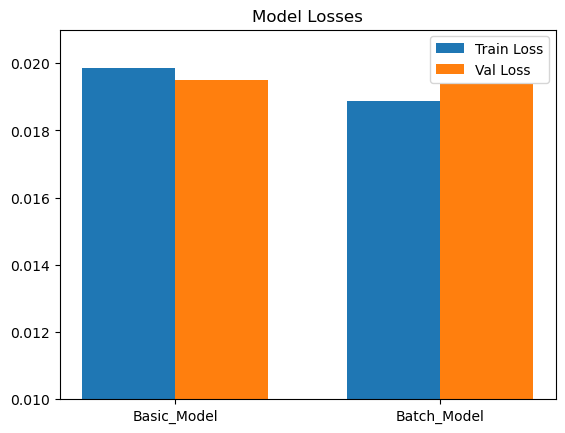

In [15]:
plot_loss_histograms(training_loss, validation_loss, names)

As we can see from the histograms, the model which performed better in terms of validation loss is the second one.

## First Section: Conclusion

After having experimented on the Mirflickr dataset using the 4 aforementioned models, we have not reached satisfactory results. All the models more or less made predictions in the same way, namely by simply coloring the whole image with a sand color. The only positive aspect was that the second model, which was also the best one, was able to correctly color the sky in some of the validation images.

Our conclusions are that the Mirflickr dataset is just too big and various, with many images of different types, which most often do not share any similarity between each other. This made it very hard for our model to pick up features and regularities in the dataset, and it caused it to simply converge to a local minimum.

We believe that all the models color the image with the light brown color because such color helps minimizing the MSE, as it is quite light and likely close to many values of the actual pixels.

The fact that there has not been much of a difference between predictions made by a very shallow model and predictions made by elaborate models with attention modules and skip connections is, in our opinion, an indicator that the dataset is just too various and hard to be learned.